In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import re
import os
import glob
from pathlib import Path
import json
from shutil import copyfile
import itertools
from collections import Counter

# analytics
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
# Spacy Imports
import spacy

from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs

def display_ent(doc):
    displacy.render(doc, style="ent", jupyter=True)

spacy_model = "en_core_web_lg"

nlp = spacy.load(spacy_model)

In [124]:
# User Source Code

import utils

In [99]:
# Project Base
base_path = Path('..')

# Data Paths
data_path = base_path / 'data'
all_reports_path = data_path / 'wamex_xml'
subset_reports_path = data_path / 'subset'
test_reports_path = data_path / 'testset'

# Event Path
events_path = base_path / 'events'

# Dictionary Paths
dictionary_path = base_path / 'dictionary'
triggers_path = dictionary_path / 'triggers'
patterns_path = dictionary_path / 'patterns'

# NLP

## Load Match Pattern Pipelines

In [72]:
patterns = []
for filename in patterns_path.iterdir():
    with open(filename, encoding="utf8") as f:
        patterns += json.load(f)
        
print(f'loaded {len(patterns)} patterns')

loaded 31120 patterns


In [22]:
patterns[:5]

[{'label': 'ROCK',
  'pattern': [{'LOWER': 'ï»¿acapulcoite'}, {'LOWER': 'meteorite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'aceite'}]},
 {'label': 'ROCK',
  'pattern': [{'LOWER': 'acid'}, {'LOWER': 'volcanic'}, {'LOWER': 'rock'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adakite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adamellite'}]}]

## Add patterns to nlp

In [73]:
ruler = EntityRuler(nlp, overwrite_ents=True)
ruler.add_patterns(patterns)

nlp.add_pipe(ruler)

## Load Trigger Words

In [74]:
trigger_words = []
for filename in triggers_path.iterdir():
    with open(filename, 'r') as f:
        trigger_words += [w.strip() for w in f.readlines()]
    
print(f'loaded {len(trigger_words)} trigger words\n')
print(trigger_words)

loaded 25 trigger words

['potential', 'drill', 'drilling', 'mineralisation', 'contain', 'promise', 'find', 'possible', 'enrich', 'enrichment', 'subeconomic', 'encouraging', 'extensive', 'patchy', 'minor', 'further drilling', 'low grade', 'medium grade', 'follow up', 'weak intercepts', 'minor intercepts', 'open at depth', 'along strike', 'exploration licence', 'prospective']


## Geology ent's to extract

In [93]:
geology_ents = ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']

# Event Extraction

In [114]:
from utils import create_event_df

eventdf = create_event_df(
    nlp=nlp, 
    directory=subset_reports_path, 
    trigger_words=trigger_words, 
    geology_ents=geology_ents,
    n_sentences_extact=2,
)

eventdf.head()

extracting events on 100 files
found 1580 events from a total of 7956 sentences


,event_id,filename,sentence_idx,sentence_text,n_trigger_words,trigger_words,event_text,ORE_DEPOSIT,ROCK,MINERAL,STRAT,LOCATION,TIMESCALE,event_label
0,a080918_e9_1443_annual_09_13904956_0,a080918_e9_1443_annual_09_13904956.json,0,following the completion of the hole and loggi...,1,[potential],following the completion of the hole and loggi...,[],[],[],[dirk hartog formation],[],[],0
1,a080918_e9_1443_annual_09_13904956_15,a080918_e9_1443_annual_09_13904956.json,15,photos of core c: yaringa e9_1443_annual_09.do...,1,[mineralisation],mineral drillholes data 2. lithology summary a...,[],[evaporite],[],[],"[australia, carnarvon basin]",[],0
2,a080918_e9_1443_annual_09_13904956_16,a080918_e9_1443_annual_09_13904956.json,16,several suitable target areas were identified ...,1,[exploration licence],lithology summary appendices 1. photos of core...,[],[evaporite],[],[],"[australia, carnarvon basin]",[],0
3,a080918_e9_1443_annual_09_13904956_18,a080918_e9_1443_annual_09_13904956.json,18,introduction the company has identified the on...,2,"[prospective, mineralisation]",several suitable target areas were identified ...,[],[sediments],[diamond],[],"[gascoyne, carnarvon basin, carnarvon basin, g...",[],0
4,a080918_e9_1443_annual_09_13904956_19,a080918_e9_1443_annual_09_13904956.json,19,the gascoyne platform is a diamond shaped area...,1,[contain],this report details the work completed on one ...,[],[sediments],[diamond],[],"[gascoyne, carnarvon basin, carnarvon basin, g...",[],0


## Save Events to csv file

In [115]:
event_path = events_path / 'group_0_events.csv'
eventdf.to_csv(event_path, index=False)

# Visualisations

## Frequency of number of trigger words found in each event

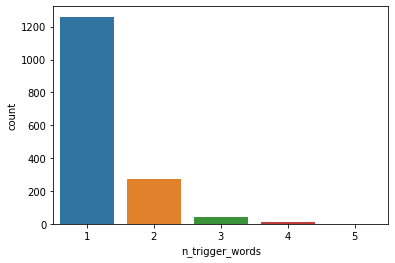

In [116]:
sns.countplot(eventdf.n_trigger_words);

## Count of each trigger word found

In [126]:
from utils import get_feature_counts_df

In [128]:
feature = 'trigger_words'
get_feature_counts_df(eventdf, feature)

,count
trigger_words,
drill,466
mineralisation,421
potential,192
contain,169
minor,132
find,105
possible,73
prospective,69
follow up,67


In [129]:
feature = 'ORE_DEPOSIT'
get_feature_counts_df(eventdf, feature)

,count
ORE_DEPOSIT,
base metal,77
uranium,72
base metals,42
lode,37
pge,36
iron ore,35
cid,33
gold deposit,31
dso,26


In [130]:
feature = 'STRAT'
get_feature_counts_df(eventdf, feature)

,count
STRAT,
ashburton formation,81
greenstone belt,55
capricorn formation,23
pincunah hill formation,18
emull gabbro,18
...,...
gooragoora sandstone member,1
woolyeenyer formation,1
cheyne springs formation,1


In [131]:
feature = 'TIMESCALE'
get_feature_counts_df(eventdf, feature)

,count
TIMESCALE,
archaean,66
proterozoic,65
cainozoic,26
tertiary,22
quaternary,15
devonian,9
frasnian,8
famennian,8
mesozoic,6


In [132]:
feature = 'LOCATION'
get_feature_counts_df(eventdf, feature)

,count
LOCATION,
western australia,103
australia,77
kambalda,74
abydos,66
long,52
...,...
mertondale,1
hornet,1
yerilla,1


# Ent Test

In [112]:
example = nlp(eventdf.iloc[0]['event_text'])
display_ent(example)

In [113]:
for ent in example.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

1969 83 87 DATE
nickel 143 149 MINERAL
copper 151 157 MINERAL
platinum 159 167 MINERAL
gold 172 176 MINERAL
australia 223 232 LOCATION
19701974 242 250 DATE
wmc resources ltd 256 273 ORG
19761979 275 283 DATE
yilgarn 381 388 PERSON
2002 392 396 DATE


In [90]:
minerals = [ent.text for ent in example.ents if ent.label_ == 'MINERAL']
minerals

['diamond']